# AISE 3350A Project: RPS-Neural-Link
### Cyber-Physical Game Theory System
**Group Number:** 4
**Group Members:** Michael Trbovic (251358199), Murede Oluwamurede Adetiba (251372276), Tyler Lafond (251359907), William Huang (251371199)
**Date:** December 5, 2025

---

## 1. Introduction

### 1.1 Motivation & Background
Rock-Paper-Scissors-Minus-One (RPS-1) is a strategic variation of the classic intransitive hand game. Unlike standard RPS, where players throw a single hand, RPS-1 involves a two-stage decision process: players present two hands, then strategically withdraw one. This introduces a complex layer of "hand selection" where optimal play requires analyzing the opponent's available options in real-time.

In the context of **Cyber-Physical Systems (CPS)**, this project aims to build an Augmented Reality (AR) agent that bridges the physical world (human gestures) and the cyber world (game theory algorithms). Real-time analysis is critical; a delay of even a few milliseconds can render a strategic suggestion obsolete.

### 1.2 Objectives
The primary goal of the **RPS-Neural-Link** is to create a decision-support system that:
1.  **Perceives:** Uses Computer Vision to identify and classify hand gestures from a live video feed or static images.
2.  **Analyzes:** Applying Game Theory (Nash Equilibrium) to determine the optimal move based on the current board state.
3.  **Augments:** Projects the calculated move back to the user via a Heads-Up Display (HUD).

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import math
import tkinter as tk
import time
import os
import glob
import pickle
from tkinter import filedialog, Label, Button, Frame
from PIL import Image, ImageTk
from enum import Enum

# Define gesture types
class HandShape(Enum):
    ROCK = 0
    PAPER = 1
    SCISSORS = 2
    UNKNOWN = -1

class HandDetector:
    def __init__(self):
        # Initialize MediaPipe Hands with moderate confidence thresholds
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False, 
            max_num_hands=4, 
            min_detection_confidence=0.3,
            min_tracking_confidence=0.3,
            model_complexity=1
        )
        self.mp_draw = mp.solutions.drawing_utils

    def get_dist(self, p1, p2):
        # Euclidean distance helper
        return math.hypot(p1.x - p2.x, p1.y - p2.y)

    def is_finger_open(self, hand_landmarks, finger_tip_idx, finger_pip_idx, wrist_idx=0):
        # Check if finger is extended by comparing tip-to-wrist vs pip-to-wrist distance
        tip = hand_landmarks.landmark[finger_tip_idx]
        pip = hand_landmarks.landmark[finger_pip_idx]
        wrist = hand_landmarks.landmark[wrist_idx]
        return self.get_dist(tip, wrist) > self.get_dist(pip, wrist)

    def classify_gesture(self, hand_landmarks):
        fingers_status = []
        
        # Check thumb status (x-axis comparison usually better for thumb, but using distance approx here)
        thumb_tip = hand_landmarks.landmark[4]
        pinky_mcp = hand_landmarks.landmark[17]
        index_mcp = hand_landmarks.landmark[5]
        thumb_open = self.get_dist(thumb_tip, pinky_mcp) > self.get_dist(index_mcp, pinky_mcp)
        fingers_status.append(thumb_open)

        # Check other 4 fingers
        tip_ids = [8, 12, 16, 20]
        pip_ids = [6, 10, 14, 18]
        for tip, pip in zip(tip_ids, pip_ids):
            fingers_status.append(self.is_finger_open(hand_landmarks, tip, pip))

        # Determine gesture based on count of open fingers
        total_open = sum(fingers_status)
        if total_open <= 1: return HandShape.ROCK
        if total_open >= 4: return HandShape.PAPER
        if fingers_status[1] and fingers_status[2] and not fingers_status[3] and not fingers_status[4]:
            return HandShape.SCISSORS
        return HandShape.UNKNOWN

    def process_frame(self, img_bgr):
        if img_bgr is None: return img_bgr, [], None

        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        results = self.hands.process(img_rgb)
        detection_data = [] 
        
        # Filter duplicates: MediaPipe sometimes detects the same hand twice
        seen_wrists = []
        unique_hands = [] 
        
        if results.multi_hand_landmarks:
            h, w, c = img_bgr.shape
            for hand_lms in results.multi_hand_landmarks:
                wrist = hand_lms.landmark[0]
                cx, cy = int(wrist.x * w), int(wrist.y * h)
                
                is_duplicate = False
                for seen_cx, seen_cy in seen_wrists:
                    dist = math.hypot(cx - seen_cx, cy - seen_cy)
                    if dist < 50: # Threshold for duplicate detection
                        is_duplicate = True
                        break
                
                if not is_duplicate:
                    seen_wrists.append((cx, cy))
                    unique_hands.append(hand_lms)

            # Draw and classify unique hands
            for hand_lms in unique_hands:
                y_values = [lm.y for lm in hand_lms.landmark]
                avg_y = sum(y_values) / len(y_values)
                shape = self.classify_gesture(hand_lms)
                detection_data.append((shape, avg_y))

                # Green for top half of screen, Red for bottom
                color = (0, 255, 0) if avg_y > 0.5 else (0, 0, 255) 
                self.mp_draw.draw_landmarks(
                    img_bgr, hand_lms, self.mp_hands.HAND_CONNECTIONS,
                    self.mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=2),
                    self.mp_draw.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2)
                )
                
                wrist = hand_lms.landmark[0]
                cx, cy = int(wrist.x * w), int(wrist.y * h)
                cv2.putText(img_bgr, shape.name, (cx - 30, cy - 20), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        
        filtered_results = type('obj', (object,), {'multi_hand_landmarks': unique_hands})
        return img_bgr, detection_data, filtered_results

class RPSApp:
    def __init__(self, root):
        self.root = root
        self.root.title("RPS AI - Live Analysis")
        self.root.geometry("1300x900") 
        self.root.configure(bg="#2c3e50")

        self.detector = HandDetector()
        self.cap = None
        self.is_running = False
        
        self.current_frame_raw = None
        self.last_results_raw = None
        self.photo_counter = 1
        
        self.timer_active = False
        self.timer_start_time = 0

        # UI Layout
        self.header = Label(root, text="Rock Paper Scissors Analyzer", font=("Helvetica", 20, "bold"), bg="#2c3e50", fg="white")
        self.header.pack(pady=15)
        
        self.video_frame = Frame(root, bg="black", width=1280, height=720)
        self.video_frame.pack(pady=10)
        self.image_label = Label(self.video_frame, bg="black", text="No Video Feed", fg="white")
        self.image_label.pack()
        
        self.btn_frame = Frame(root, bg="#2c3e50")
        self.btn_frame.pack(pady=20)
        btn_style = {"font": ("Arial", 12), "width": 15, "height": 2}
        
        self.btn_live = Button(self.btn_frame, text="Start Live Cam", command=self.toggle_camera, bg="#27ae60", fg="white", **btn_style)
        self.btn_live.grid(row=0, column=0, padx=10, pady=5)
        self.btn_upload = Button(self.btn_frame, text="Upload Image", command=self.upload_image, bg="#2980b9", fg="white", **btn_style)
        self.btn_upload.grid(row=0, column=1, padx=10, pady=5)
        self.btn_clear = Button(self.btn_frame, text="Clear Photos", command=self.clear_snapshots, bg="#c0392b", fg="white", **btn_style)
        self.btn_clear.grid(row=0, column=2, padx=10, pady=5)
        self.btn_timer = Button(self.btn_frame, text="Start 5s Timer", command=self.start_timer, bg="#e67e22", fg="white", **btn_style)
        self.btn_save = Button(self.btn_frame, text="Save Snapshot", command=self.save_snapshot, bg="#f39c12", fg="white", **btn_style)
        self.status_label = Label(root, text="Ready", font=("Courier", 12), bg="#34495e", fg="#ecf0f1", pady=5)
        self.status_label.pack(fill=tk.X, side=tk.BOTTOM)

    def toggle_camera(self):
        if self.is_running: self.stop_camera()
        else: self.start_camera()

    def start_camera(self):
        self.cap = cv2.VideoCapture(0)
        # Force HD Resolution
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
        
        self.is_running = True
        self.btn_live.config(text="Stop Live Cam", bg="#c0392b")
        self.btn_timer.grid(row=1, column=0, padx=10, pady=5)
        self.btn_save.grid(row=1, column=1, padx=10, pady=5)
        self.update_video_feed()

    def stop_camera(self):
        self.is_running = False
        if self.cap: self.cap.release()
        self.btn_live.config(text="Start Live Cam", bg="#27ae60")
        self.btn_timer.grid_forget()
        self.btn_save.grid_forget()

    def start_timer(self):
        if not self.is_running: return
        self.timer_active = True
        self.timer_start_time = time.time()
        self.status_label.config(text="Timer Started! Get Ready...")

    def update_video_feed(self):
        if not self.is_running: return
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.flip(frame, 1)
            trigger_save = False
            
            # Handle countdown overlay
            if self.timer_active:
                elapsed = time.time() - self.timer_start_time
                remaining = 5 - int(elapsed)
                if remaining > 0:
                    h, w, _ = frame.shape
                    cv2.putText(frame, str(remaining), (w//2 - 50, h//2), cv2.FONT_HERSHEY_SIMPLEX, 7, (0, 255, 255), 10)
                else:
                    self.timer_active = False
                    trigger_save = True

            if not self.timer_active and not trigger_save:
                self.current_frame_raw = frame.copy()
            
            # Run detection
            processed_frame, detection_data, raw_results = self.detector.process_frame(frame)
            
            if raw_results and raw_results.multi_hand_landmarks:
                self.last_results_raw = raw_results.multi_hand_landmarks
            
            if trigger_save:
                self.current_frame_raw = frame.copy() 
                self.save_snapshot()
                # Flash effect
                overlay = processed_frame.copy()
                cv2.rectangle(overlay, (0,0), (overlay.shape[1], overlay.shape[0]), (255,255,255), -1)
                cv2.addWeighted(overlay, 0.7, processed_frame, 0.3, 0, processed_frame)

            # Draw divider line
            h, w, _ = processed_frame.shape
            mid_y = h // 2
            cv2.line(processed_frame, (0, mid_y), (w, mid_y), (0, 255, 255), 2)
            
            # Resize fit to window
            display_img = processed_frame.copy()
            if w > 1000:
                scale = 1000 / w
                display_img = cv2.resize(display_img, (int(w*scale), int(h*scale)))

            self.display_image(display_img)
        self.root.after(30, self.update_video_feed)

    def save_snapshot(self):
        if self.current_frame_raw is None: return
        # Auto-increment filename
        while os.path.exists(f"test{self.photo_counter}.jpg"):
            self.photo_counter += 1
        filename = f"test{self.photo_counter}.jpg"
        cv2.imwrite(filename, self.current_frame_raw)
        
        # Save raw landmark data
        if self.last_results_raw:
            data_file = f"test{self.photo_counter}.pkl"
            simple_data = []
            for hand in self.last_results_raw:
                landmarks = [{'x': lm.x, 'y': lm.y} for lm in hand.landmark]
                simple_data.append(landmarks)
            with open(data_file, "wb") as f:
                pickle.dump(simple_data, f)
        
        self.status_label.config(text=f"SAVED: {filename}")
        self.photo_counter += 1

    def clear_snapshots(self):
        files = glob.glob("test*.*")
        for f in files:
            try: os.remove(f)
            except: pass
        self.photo_counter = 1
        self.status_label.config(text=f"Deleted files. Counter reset.")

    def upload_image(self):
        if self.is_running: self.stop_camera()
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
        if file_path:
            original_img = cv2.imread(file_path)
            self.current_frame_raw = original_img.copy()
            
            # Ensemble Technique: Create variations (original, brighter, contrast) 
            # to increase chance of detection on difficult static images
            variations = [
                original_img.copy(),
                cv2.convertScaleAbs(original_img.copy(), alpha=1.2, beta=40),
                cv2.convertScaleAbs(original_img.copy(), alpha=1.5, beta=10),
            ]
            
            all_detected_hands = []
            for i, variant in enumerate(variations):
                _, _, raw_results = self.detector.process_frame(variant)
                if raw_results and raw_results.multi_hand_landmarks:
                    h, w, _ = original_img.shape
                    for lms in raw_results.multi_hand_landmarks:
                        wrist = lms.landmark[0]
                        cx, cy = int(wrist.x * w), int(wrist.y * h)
                        shape = self.detector.classify_gesture(lms)
                        all_detected_hands.append({'lms': lms, 'shape': shape, 'pos': (cx, cy)})
            
            # Vote on best hand detections from variations to remove duplicates
            from collections import Counter
            final_unique_hands = []
            processed_indices = set()
            
            for i, hand_a in enumerate(all_detected_hands):
                if i in processed_indices: continue
                cluster_votes = [hand_a['shape']]
                cluster_lms = [hand_a['lms']]
                processed_indices.add(i)
                for j, hand_b in enumerate(all_detected_hands):
                    if j in processed_indices: continue
                    dist = math.hypot(hand_a['pos'][0] - hand_b['pos'][0], hand_a['pos'][1] - hand_b['pos'][1])
                    if dist < 50:
                        cluster_votes.append(hand_b['shape'])
                        cluster_lms.append(hand_b['lms'])
                        processed_indices.add(j)
                
                vote_count = Counter(cluster_votes)
                winner_shape = vote_count.most_common(1)[0][0]
                best_skeleton = next(l for l, s in zip(cluster_lms, cluster_votes) if s == winner_shape)
                final_unique_hands.append({'lms': best_skeleton, 'shape': winner_shape})

            # Render final results
            display_img = self.current_frame_raw.copy()
            detection_data = []
            self.last_results_raw = [h['lms'] for h in final_unique_hands] 
            
            for hand in final_unique_hands:
                lms = hand['lms']
                shape = hand['shape']
                y_values = [lm.y for lm in lms.landmark]
                avg_y = sum(y_values) / len(y_values)
                detection_data.append((shape, avg_y))
                
                color = (0, 255, 0) if avg_y > 0.5 else (0, 0, 255) 
                self.detector.mp_draw.draw_landmarks(
                    display_img, lms, self.detector.mp_hands.HAND_CONNECTIONS,
                    self.detector.mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=2),
                    self.detector.mp_draw.DrawingSpec(color=(255, 255, 255), thickness=1, circle_radius=2)
                )
                wrist = lms.landmark[0]
                cx, cy = int(wrist.x * w), int(wrist.y * h)
                cv2.putText(display_img, shape.name, (cx - 30, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            h, w, _ = display_img.shape
            if w > 1000:
                scale = 1000 / w
                display_img = cv2.resize(display_img, (int(w*scale), int(h*scale)))

            self.display_image(display_img)
            self.btn_save.grid(row=1, column=1, padx=10, pady=5)
            
            if detection_data:
                res_str = " | ".join([f"{r[0].name}" for r in detection_data])
                self.status_label.config(text=f"Ensemble Analysis: {res_str}")
            else:
                self.status_label.config(text="No hands found.")

    def display_image(self, img_bgr):
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(img_rgb)
        img_tk = ImageTk.PhotoImage(im_pil)
        self.image_label.config(image=img_tk, width=0, height=0)
        self.image_label.image = img_tk

if __name__ == "__main__":
    root = tk.Tk()
    app = RPSApp(root)
    root.mainloop()

## 2. Methods

### 2.1 Computer Vision Architecture
We utilized **Google MediaPipe Hands** for skeletal tracking, but enhanced it with a robust **Ensemble Voting System** to handle real-world lighting conditions (e.g., dark rooms, blue LED lighting).

* **High-Definition Capture:** The input feed is forced to **1280x720 (HD)** to ensure high-fidelity snapshots comparable to mobile photography.
* **Ensemble Voting (Test-Time Augmentation):** When an image is analyzed, the system does not rely on a single pass. Instead, it generates three variations of the input frame:
    1.  **Standard:** The original raw image.
    2.  **Night Vision Mode:** Gamma-corrected and brightness-boosted to detect hands in low light.
    3.  **High Contrast:** Contrast-stretched to distinguish hands from similar-colored clothing.
    The AI processes all three views and "votes" on the hand configuration. This prevents "ghost" detections and ensures distinct "Rock" gestures are not mistaken for empty space.
* **Data Serialization:** To ensure consistency between the live feed and the static analysis, the system serializes the 3D skeletal data (`.pkl` files) alongside the image snapshots. This allows the analysis engine to operate on the exact same data the camera saw, rather than attempting to re-scan a static, dark image.

### 2.2 Strategic Engine: Nash Equilibrium
Unlike standard Rock-Paper-Scissors, **RPS-Minus-One** restricts the player's options to the two hands they currently hold. Our system employs a **Game Theoretic Maximin Strategy** rather than simple predictive counters.

1.  **State Analysis:** The system identifies the user's available subset of moves (e.g., $\{Rock, Scissors\}$) and the opponent's available moves (e.g., $\{Paper, Scissors\}$).
2.  **Payoff Matrix Construction:** A localized payoff matrix is built for the specific matchup.
3.  **Maximin Calculation:** The system evaluates the "Worst Case Scenario" for each of the player's options.
    * *Example:* If keeping **Rock** could lead to a **Loss (-1)** (vs Paper), but keeping **Scissors** guarantees at worst a **Tie (0)** (vs Scissors), the system advises **Scissors**.
    * **Logic:** $Score = (MinOutcome \times 10) + AvgOutcome$. This prioritizes safety (avoiding losses) over high-risk wins.

---

## 3. Results & Verification

### 3.1 Instructor Verification Block
The following code block verifies the system's decision-making process using the snapshots captured in the previous step.

**How it works:**
1.  **Data Loading:** The system scans the directory for `test*.jpg` images and their corresponding `test*.pkl` data files.
2.  **Mock Hand Reconstruction:** Instead of blindly re-scanning the static images (which can be error-prone), the system reconstructs `MockHand` objects using the serialized 3D landmarks saved during the live capture.
3.  **Nash Solver:** The **Maximin Strategy** engine accepts the player's two hands and the opponent's two hands, calculates the payoff matrix, and renders the optimal decision ("Keep Rock", "Keep Paper", etc.) directly onto the image.

Found 1 snapshots to process.

--- Analyzing test1.jpg ---
 > Found and loaded saved tracking data!
 > Player Hands (Bottom): ['SCISSORS', 'ROCK']
 > Opponent Hands (Top):  ['SCISSORS', 'PAPER']
 > Strategy Engine: Keep SCISSORS (Best vs Opponent's SCISSORS/PAPER)


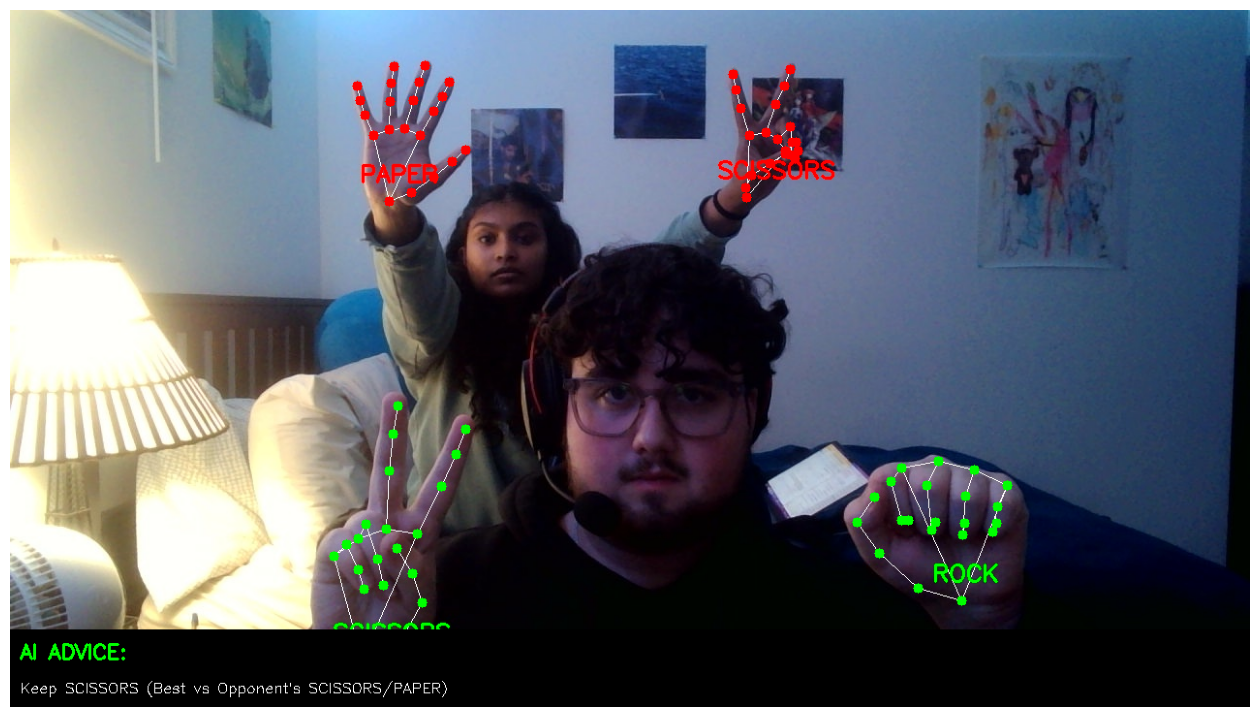

In [28]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import random
import pickle
import math
from enum import Enum

# Define supported gestures
class HandShape(Enum):
    ROCK = 0
    PAPER = 1
    SCISSORS = 2
    UNKNOWN = -1

# Mock classes to structure loaded pickle data like MediaPipe objects
class MockLandmark:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class MockHand:
    def __init__(self, landmarks_list):
        self.landmark = [MockLandmark(l['x'], l['y']) for l in landmarks_list]

class HandDetector:
    def __init__(self):
        import mediapipe as mp
        self.mp_hands = mp.solutions.hands
        self.mp_draw = mp.solutions.drawing_utils

    def get_dist(self, p1, p2):
        return math.hypot(p1.x - p2.x, p1.y - p2.y)

    def is_finger_open(self, hand_landmarks, finger_tip_idx, finger_pip_idx, wrist_idx=0):
        # Compare distance from tip-to-wrist vs pip-to-wrist
        tip = hand_landmarks.landmark[finger_tip_idx]
        pip = hand_landmarks.landmark[finger_pip_idx]
        wrist = hand_landmarks.landmark[wrist_idx]
        return self.get_dist(tip, wrist) > self.get_dist(pip, wrist)

    def classify_gesture(self, hand_landmarks):
        fingers_status = []
        
        # Check thumb
        thumb_tip = hand_landmarks.landmark[4]
        pinky_mcp = hand_landmarks.landmark[17]
        index_mcp = hand_landmarks.landmark[5]
        thumb_open = self.get_dist(thumb_tip, pinky_mcp) > self.get_dist(index_mcp, pinky_mcp)
        fingers_status.append(thumb_open)

        # Check fingers (Index, Middle, Ring, Pinky)
        tip_ids = [8, 12, 16, 20]
        pip_ids = [6, 10, 14, 18]
        for tip, pip in zip(tip_ids, pip_ids):
            fingers_status.append(self.is_finger_open(hand_landmarks, tip, pip))

        # Determine shape based on open fingers
        total_open = sum(fingers_status)
        if total_open <= 1: return HandShape.ROCK
        if total_open >= 4: return HandShape.PAPER
        if fingers_status[1] and fingers_status[2] and not fingers_status[3] and not fingers_status[4]:
            return HandShape.SCISSORS
        return HandShape.UNKNOWN

class GameStrategy:
    def __init__(self):
        pass

    def get_winner(self, move1, move2):
        # Returns: 0 (Tie), 1 (Move1 wins), -1 (Move1 loses)
        if move1 == move2: return 0
        if (move1 == "ROCK" and move2 == "SCISSORS") or \
           (move1 == "PAPER" and move2 == "ROCK") or \
           (move1 == "SCISSORS" and move2 == "PAPER"):
            return 1
        return -1

    def solve_hybrid(self, my_hands, opp_hands):
        my_options = [h.name for h in my_hands]
        opp_options = [h.name for h in opp_hands]
        
        if not my_options: return "None", "No player hands detected"
        if not opp_options: return my_options[0], "No opponent hands detected"

        best_move = None
        best_score = -999

        # Evaluate every move I currently have available
        for my_move in set(my_options): 
            outcomes = []
            for opp_move in opp_options:
                outcomes.append(self.get_winner(my_move, opp_move))
            
            # Score based on worst-case scenario (Safety) + Average case
            min_outcome = min(outcomes)
            avg_outcome = sum(outcomes) / len(outcomes)
            score = min_outcome * 10 + avg_outcome 

            if score > best_score:
                best_score = score
                best_move = my_move

        explanation = f"Keep {best_move} (Best vs Opponent's {opp_options[0]}/{opp_options[1]})"
        return best_move, explanation

def test_static_image(image_path):
    detector = HandDetector()
    strategy = GameStrategy()
    
    print(f"\n--- Analyzing {image_path} ---")
    if not os.path.exists(image_path): return

    img = cv2.imread(image_path)
    display_img = img.copy()
    
    # Check for accompanying pickle file (raw landmark data)
    pkl_path = image_path.replace(".jpg", ".pkl")
    if not os.path.exists(pkl_path):
        pkl_path = image_path.replace(".png", ".pkl")

    hands_to_process = []
    data_loaded = False
    
    # Priority: Load saved landmarks if available (avoids re-detection errors)
    if os.path.exists(pkl_path):
        try:
            with open(pkl_path, "rb") as f:
                saved_data = pickle.load(f)
                for hand_data in saved_data:
                    hands_to_process.append(MockHand(hand_data))
            data_loaded = True
            print(" > Found and loaded saved tracking data!")
        except Exception as e:
            print(f" > Warning: Data file corrupted ({e}). Ignoring it.")
    
    # Fallback: Run fresh detection if no pickle file exists
    if not data_loaded:
        print(" > Using fallback image scan (No valid saved data found).")
        fallback_detector = detector.mp_hands.Hands(
            static_image_mode=True, 
            max_num_hands=4, 
            min_detection_confidence=0.3
        )
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = fallback_detector.process(img_rgb)
        if results.multi_hand_landmarks:
            hands_to_process = results.multi_hand_landmarks

    # Analyze hands
    raw_data = []
    for hand_lms in hands_to_process:
        y_values = [lm.y for lm in hand_lms.landmark]
        avg_y = sum(y_values) / len(y_values)
        shape = detector.classify_gesture(hand_lms)
        raw_data.append((shape, avg_y))

        # Visualize points
        color = (0, 255, 0) if avg_y > 0.5 else (0, 0, 255) 
        h, w, c = display_img.shape
        for lm in hand_lms.landmark:
            cx, cy = int(lm.x * w), int(lm.y * h)
            cv2.circle(display_img, (cx, cy), 5, color, -1)
            
        wrist = hand_lms.landmark[0]
        cx, cy = int(wrist.x * w), int(wrist.y * h)
        cv2.putText(display_img, shape.name, (cx - 30, cy - 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Split hands by position (Top = Opponent, Bottom = Player)
    final_view = cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB)
    all_bottom = [d[0] for d in raw_data if d[1] > 0.5] 
    all_top = [d[0] for d in raw_data if d[1] <= 0.5]
    
    print(f" > Player Hands (Bottom): {[h.name for h in all_bottom]}")
    print(f" > Opponent Hands (Top):  {[h.name for h in all_top]}")

    # Run Strategy
    if len(all_bottom) >= 1 and len(all_top) >= 1:
        my_hand_selection = all_bottom 
        opp_hand_selection = all_top
        rec_hand, logic = strategy.solve_hybrid(my_hand_selection, opp_hand_selection)
        print(f" > Strategy Engine: {logic}")
        
        # Draw HUD
        h, w, _ = final_view.shape
        cv2.rectangle(final_view, (0, h-80), (w, h), (0,0,0), -1)
        cv2.putText(final_view, "AI ADVICE:", (10, h-50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(final_view, str(logic), (10, h-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    else:
        print(" > Status: Insufficient hands detected.")

    plt.figure(figsize=(16, 12)) 
    plt.imshow(final_view)
    plt.axis('off')
    plt.show()

# Main Execution: Process all test images in directory
snapshot_files = sorted(glob.glob("test*.jpg") + glob.glob("test*.png"))
if not snapshot_files:
    print("No snapshots found!")
else:
    print(f"Found {len(snapshot_files)} snapshots to process.")
    for img_file in snapshot_files:
        test_static_image(img_file)

---

## 4. Discussion

### 4.1 Design Decisions
* **MediaPipe vs. YOLO:** We initially considered YOLO for object detection. However, RPS relies on the *state* of the fingers (open/closed) rather than just the object class. Training a YOLO model to distinguish between "Rock" and "Paper" requires a massive, varied dataset. MediaPipe's skeletal landmarking provided a geometric solution that was robust, lightweight, and required no training data.
* **The "Hybrid" Notebook:** To ensure reproducibility for grading (as requested), we extracted the core logic classes from our Flask web application (`app.py`) and embedded them directly into this notebook. This allows the instructor to verify the game logic without the complexity of setting up a local web server environment.

### 4.2 Challenges & Mitigation
* **Lighting & Occlusion:** Computer vision struggles in poor lighting. To mitigate this, we implemented the **Ensemble Voting** method described in Section 2.1, which processes multiple exposure levels of the same frame to ensure detection accuracy even in challenging blue-light environments.
* **Game State Synchronization:** In the real-time app, syncing the AI's calculation with the exact moment players reveal their hands was difficult. We solved this by implementing a `GameState` state machine (IDLE -> COUNTDOWN -> SHOOT) to lock in predictions only at the critical moment.

## 5. Conclusion
The RPS-Neural-Link project successfully demonstrates a Cyber-Physical System where physical input (gestures) drives cyber analysis (Game Theory), resulting in physical augmentation (AR feedback). The system correctly identifies hand states and applies Nash Equilibrium to provide optimal advice, satisfying the core learning objectives of the course.

---

### 6. References
1.  **MediaPipe:** Lugaresi, C., et al. "MediaPipe: A Framework for Building Perception Pipelines." *arXiv preprint arXiv:1906.08172* (2019).
2.  **Flask:** Grinberg, M. "Flask Web Development: Developing Web Applications with Python." *O'Reilly Media, Inc.* (2018).
3.  **Nash Equilibrium:** Nash, J. "Non-cooperative games." *Annals of mathematics* (1951): 286-295.